# Using the expression of genes on the X-chromosome to predict young or aged cells (5/5-- evaluation and intepretatin)

## Outline

The **Xgene** workflow consists of four sections:

I. Exploratory data analysis (EDA) (1/5)

II. preprocessing and model tunning (2/5)

III. Model comparison (3/5)

IV. Final model over 50 random states (4/5)

V. Results and intepretations (5/5, this notebook)
1. [Evaluation of the best model-- XGBoost](#5.-eval)
    - [Normalized cofusion matrix](#6.-cm)
    - [ROC curve](#7.-ROC)


2. [Interpretation of the best model -- XGBoost](#8.-interp)
    - [Global -- a). permutation feature importance](#9.-permut)
    - [Global -- b). important features for all 5 metrics in XGBoost](#10.-metrics)
    - [Global -- c) SHAP](#11.-shap)
    - [Local (check some data points/ observations) -- SHAP](#12.-shap2)

## 1. Thorough evaluation of the best model<a name="5.-eval"></a>
### a) Normalized cofusion matrix<a name="6.-cm"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, ParameterGrid
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

import tqdm
from tqdm import tqdm

import xgboost
from xgboost import XGBClassifier

In [2]:
file = open('./results/xgbc_final.save', 'rb')
xgbc_final = pickle.load(file)
file.close()

file = open('./data/test_sets_final.save', 'rb')
test_sets_final = pickle.load(file)
file.close()

In [3]:
from statistics import mean, stdev
def get_scores_acc_50(model, baseline=False):
    
    scores = []
    for i in range(0, 50):
        X_test, y_test = test_sets_final[i]
        
        if baseline:
            scores.append(max(y_test.value_counts())/len(y_test))
        
        else:
            clf = model[i]
            y_pred = clf.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        
        
    print(f'accuracy: {mean(scores)} ± {stdev(scores)}' )

In [4]:
print('baseline scores:') 
get_scores_acc_50(xgbc_final, baseline=True)

print('\nmodel scores:')
get_scores_acc_50(xgbc_final)

baseline scores:
accuracy: 0.5956968606278744 ± 0.007651649881343652

model scores:
accuracy: 0.7775244951009798 ± 0.006224049216488766


In [5]:
from sklearn.metrics import confusion_matrix
def get_cm(model, nrun):
    
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    for i in range(nrun):
        X_test, y_test = test_sets_final[i]
        
        clf = model[i]
        
        y_pred = clf.predict(X_test)
        
        # calculate the sum of tn, fp, fn, tp to get the mean values to calculate cm
        cm = confusion_matrix(y_test, y_pred)

        tn += cm[0,0]
        fp += cm[0,1]
        fn += cm[1,0]
        tp += cm[1,1]
         
    # mean tn, fp, fn, tp --> cm (mean)
    cm = np.array([[tn/nrun, fp/nrun], [fn/nrun, tp/nrun]])
    
    # normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return cm

def plot_cm(cm, classes):    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Normalized (mean) confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] == thresh else "white")
    fig.tight_layout()
    return ax

In [6]:
cm = get_cm(xgbc_final, 50)
cm

array([[0.67455686, 0.32544314],
       [0.15259073, 0.84740927]])

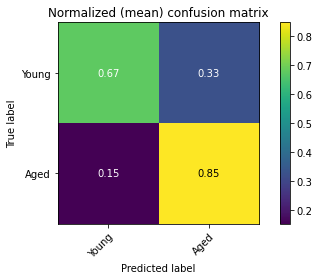

In [7]:
plot_cm(cm, classes=['Young','Aged'])
plt.savefig('./figures/final_cm.pdf')
plt.show()

### b) ROC curve<a name="7.-ROC"></a>

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

def get_roc_curve(model):
    fig = plt.figure()
    scores = []
    for i in range(0, 50, 5):
        X_test, y_test = test_sets_final[i]
        
        if i==0:
            disp_0 = plot_roc_curve(model[0], X_test, y_test, name=i)
        else:
            plot_roc_curve(model[i], X_test, y_test, name=i, ax=disp_0.ax_)

    plt.rcParams.update({'font.size': 12})   
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r') 
    plt.title('ROC curve over 10 random states')
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig('./figures/final_ROC.pdf')
    return fig

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

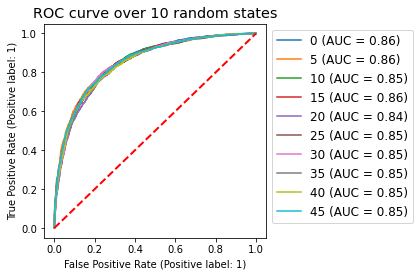

In [9]:
get_roc_curve(xgbc_final)

## 2. Interpretation of the best model<a name="8.-interp"></a>
### a) Global -- permutation feature importance<a name="9.-permut"></a>

In [11]:
file = open('./data/feature_names.save', 'rb')
feature_names = pickle.load(file)
file.close()

In [12]:
from sklearn.inspection import permutation_importance

np.random.seed(42)

ftr_names = feature_names
nr_runs = 10

scores = np.zeros([len(ftr_names),nr_runs])

X_test5, y_test5 = test_sets_final[5]
X_test = X_test5
y_test = y_test5
grid = xgbc_final[5]

# loop through the features

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    acc_scores = []
   
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

shuffling Gm26618
   shuffled test score: 0.782 +/- 0.0
shuffling Clcn5
   shuffled test score: 0.782 +/- 0.0
shuffling Syp
   shuffled test score: 0.781 +/- 0.001
shuffling Gm14703
   shuffled test score: 0.783 +/- 0.001
shuffling Gpkow
   shuffled test score: 0.782 +/- 0.001
shuffling Praf2
   shuffled test score: 0.782 +/- 0.0
shuffling Gripap1
   shuffled test score: 0.781 +/- 0.001
shuffling Otud5
   shuffled test score: 0.782 +/- 0.0
shuffling Pim2
   shuffled test score: 0.783 +/- 0.001
shuffling Slc35a2
   shuffled test score: 0.782 +/- 0.001
shuffling Pcsk1n
   shuffled test score: 0.768 +/- 0.001
shuffling Hdac6
   shuffled test score: 0.781 +/- 0.001
shuffling Wdr13
   shuffled test score: 0.783 +/- 0.0
shuffling Rbm3
   shuffled test score: 0.781 +/- 0.001
shuffling Porcn
   shuffled test score: 0.782 +/- 0.0
shuffling B630019K06Rik
   shuffled test score: 0.782 +/- 0.0
shuffling Dynlt3
   shuffled test score: 0.783 +/- 0.0
shuffling Rpgr
   shuffled test score: 0.782 +/- 0

   shuffled test score: 0.783 +/- 0.001
shuffling Rps4x
   shuffled test score: 0.782 +/- 0.001
shuffling Gm14858
   shuffled test score: 0.782 +/- 0.0
shuffling Hdac8
   shuffled test score: 0.781 +/- 0.001
shuffling Phka1
   shuffled test score: 0.781 +/- 0.001
shuffling Chic1
   shuffled test score: 0.781 +/- 0.001
shuffling Tsix
   shuffled test score: 0.743 +/- 0.003
shuffling Xist
   shuffled test score: 0.649 +/- 0.007
shuffling Jpx
   shuffled test score: 0.781 +/- 0.001
shuffling Ftx
   shuffled test score: 0.777 +/- 0.002
shuffling Slc16a2
   shuffled test score: 0.782 +/- 0.0
shuffling Rlim
   shuffled test score: 0.782 +/- 0.0
shuffling Nexmif
   shuffled test score: 0.78 +/- 0.001
shuffling Abcb7
   shuffled test score: 0.782 +/- 0.0
shuffling 5530601H04Rik
   shuffled test score: 0.78 +/- 0.001
shuffling Pbdc1
   shuffled test score: 0.782 +/- 0.0
shuffling Magee1
   shuffled test score: 0.783 +/- 0.001
shuffling 5330434G04Rik
   shuffled test score: 0.78 +/- 0.002
shuffl

   shuffled test score: 0.782 +/- 0.0
shuffling x0_Npsr1/Unc13c
   shuffled test score: 0.782 +/- 0.001
shuffling x0_Nrg1/Nnat
   shuffled test score: 0.782 +/- 0.0
shuffling x0_Nrxn3/Sox2ot
   shuffled test score: 0.783 +/- 0.001
shuffling x0_Pard3b/Tac1
   shuffled test score: 0.782 +/- 0.0
shuffling x0_Pdzrn4/Kcnq5
   shuffled test score: 0.781 +/- 0.0
shuffling x0_Plp1/Ptgds
   shuffled test score: 0.782 +/- 0.0
shuffling x0_Pomc/Tac2
   shuffled test score: 0.782 +/- 0.001
shuffling x0_Rfx4/Hcrt
   shuffled test score: 0.783 +/- 0.0
shuffling x0_Rgs6/B230323A14Rik
   shuffled test score: 0.783 +/- 0.0
shuffling x0_Rnf220/Ntng1
   shuffled test score: 0.782 +/- 0.0
shuffling x0_Satb2/Rab3b
   shuffled test score: 0.782 +/- 0.0
shuffling x0_Sgcd/Tac1
   shuffled test score: 0.779 +/- 0.001
shuffling x0_Slc1a3/Apoe
   shuffled test score: 0.782 +/- 0.0
shuffling x0_Slit3/Cacna2d1
   shuffled test score: 0.783 +/- 0.001
shuffling x0_Sox2ot/Gal
   shuffled test score: 0.782 +/- 0.0
shu

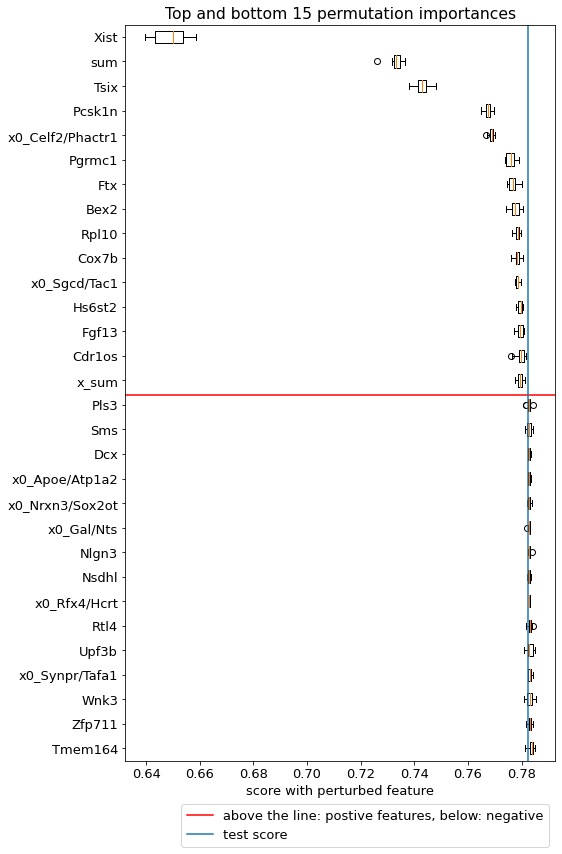

In [13]:
test_score = grid.score(X_test,y_test)

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]

top15 = sorted_indcs[-15:]
low15 = sorted_indcs[:15]
tl15 = np.append(low15, top15)

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(8, 12))
plt.boxplot(scores[tl15].T,labels=np.array(ftr_names)[tl15],vert=False)
plt.axhline(y= 15.4, color='r', label='above the line: postive features, below: negative')
plt.axvline(test_score, label='test score')
plt.title("Top and bottom 15 permutation importances")
plt.xlabel('score with perturbed feature')
plt.legend(bbox_to_anchor=(1, -0.05))
plt.tight_layout()
plt.savefig('./figures/final_permutation_importance_rs5.pdf')
plt.show()

In [14]:
# for another random state
np.random.seed(42)

ftr_names = feature_names
nr_runs = 10

scores = np.zeros([len(ftr_names),nr_runs])

X_test42, y_test42 = test_sets_final[42]
X_test = X_test42
y_test = y_test42
grid = xgbc_final[42]

# loop through the features

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    acc_scores = []
   
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

shuffling Gm26618
   shuffled test score: 0.779 +/- 0.0
shuffling Clcn5
   shuffled test score: 0.779 +/- 0.0
shuffling Syp
   shuffled test score: 0.778 +/- 0.001
shuffling Gm14703
   shuffled test score: 0.78 +/- 0.001
shuffling Gpkow
   shuffled test score: 0.78 +/- 0.0
shuffling Praf2
   shuffled test score: 0.779 +/- 0.0
shuffling Gripap1
   shuffled test score: 0.778 +/- 0.001
shuffling Otud5
   shuffled test score: 0.779 +/- 0.0
shuffling Pim2
   shuffled test score: 0.778 +/- 0.0
shuffling Slc35a2
   shuffled test score: 0.778 +/- 0.0
shuffling Pcsk1n
   shuffled test score: 0.77 +/- 0.002
shuffling Hdac6
   shuffled test score: 0.779 +/- 0.001
shuffling Wdr13
   shuffled test score: 0.779 +/- 0.0
shuffling Rbm3
   shuffled test score: 0.779 +/- 0.0
shuffling Porcn
   shuffled test score: 0.779 +/- 0.0
shuffling B630019K06Rik
   shuffled test score: 0.779 +/- 0.0
shuffling Dynlt3
   shuffled test score: 0.779 +/- 0.0
shuffling Rpgr
   shuffled test score: 0.779 +/- 0.0
shufflin

   shuffled test score: 0.779 +/- 0.001
shuffling Gm14858
   shuffled test score: 0.779 +/- 0.0
shuffling Hdac8
   shuffled test score: 0.778 +/- 0.001
shuffling Phka1
   shuffled test score: 0.779 +/- 0.001
shuffling Chic1
   shuffled test score: 0.78 +/- 0.0
shuffling Tsix
   shuffled test score: 0.743 +/- 0.003
shuffling Xist
   shuffled test score: 0.648 +/- 0.003
shuffling Jpx
   shuffled test score: 0.781 +/- 0.001
shuffling Ftx
   shuffled test score: 0.776 +/- 0.001
shuffling Slc16a2
   shuffled test score: 0.779 +/- 0.001
shuffling Rlim
   shuffled test score: 0.779 +/- 0.0
shuffling Nexmif
   shuffled test score: 0.778 +/- 0.001
shuffling Abcb7
   shuffled test score: 0.779 +/- 0.001
shuffling 5530601H04Rik
   shuffled test score: 0.779 +/- 0.001
shuffling Pbdc1
   shuffled test score: 0.779 +/- 0.0
shuffling Magee1
   shuffled test score: 0.778 +/- 0.0
shuffling 5330434G04Rik
   shuffled test score: 0.777 +/- 0.002
shuffling Atrx
   shuffled test score: 0.779 +/- 0.001
shuff

   shuffled test score: 0.779 +/- 0.0
shuffling x0_Npsr1/Unc13c
   shuffled test score: 0.779 +/- 0.001
shuffling x0_Nrg1/Nnat
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Nrxn3/Sox2ot
   shuffled test score: 0.779 +/- 0.001
shuffling x0_Pard3b/Tac1
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Pdzrn4/Kcnq5
   shuffled test score: 0.778 +/- 0.001
shuffling x0_Plp1/Ptgds
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Pomc/Tac2
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Rfx4/Hcrt
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Rgs6/B230323A14Rik
   shuffled test score: 0.777 +/- 0.0
shuffling x0_Rnf220/Ntng1
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Satb2/Rab3b
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Sgcd/Tac1
   shuffled test score: 0.775 +/- 0.001
shuffling x0_Slc1a3/Apoe
   shuffled test score: 0.779 +/- 0.0
shuffling x0_Slit3/Cacna2d1
   shuffled test score: 0.779 +/- 0.001
shuffling x0_Sox2ot/Gal
   shuffled test score: 0.778 +/- 0.001
s

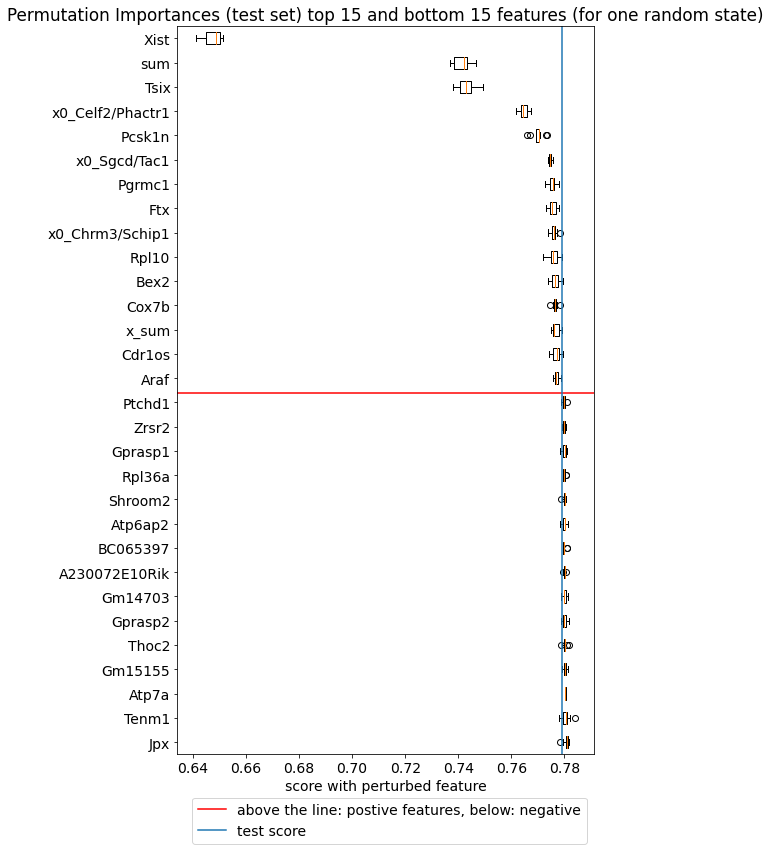

In [15]:
test_score = grid.score(X_test,y_test)

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]

top15 = sorted_indcs[-15:]
low15 = sorted_indcs[:15]
tl15 = np.append(low15, top15)

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 12))
plt.boxplot(scores[tl15].T,labels=np.array(ftr_names)[tl15],vert=False)
plt.axhline(y= 15.4, color='r', label='above the line: postive features, below: negative')
plt.axvline(test_score, label='test score')
plt.title("Permutation Importances (test set) top 15 and bottom 15 features (for one random state)")
plt.xlabel('score with perturbed feature')
plt.legend(bbox_to_anchor=(1, -0.05))
plt.tight_layout()
plt.savefig('./figures/final_permutation_importance_rs42.pdf')
plt.show()

### b) Global -- important features for all 5 metrics in XGBoost<a name="10.-metrics"></a>

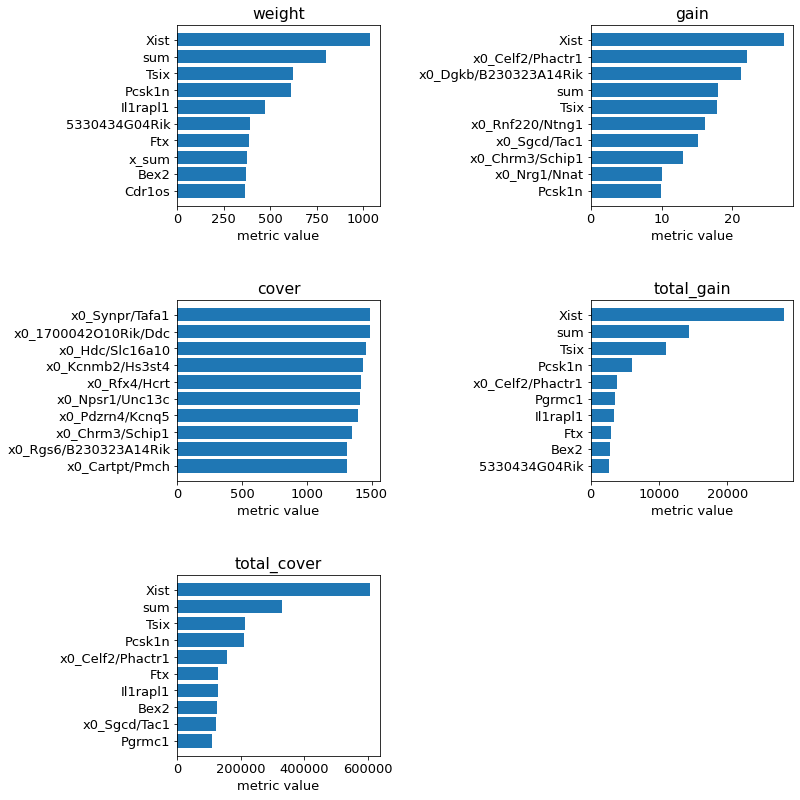

In [16]:
# use the fifth random state
model = xgbc_final[5]
metrics = ['weight','gain','cover','total_gain','total_cover']

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12,12))
for i in range(len(metrics)):
    scores = model.get_booster().get_score(importance_type=metrics[i])
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
    
    plt.subplot(3, 2, i+1)
    plt.barh(list(scores.keys())[-10:], list(scores.values())[-10:], align='center')
    plt.title(metrics[i])
    plt.xlabel('metric value')
plt.tight_layout(pad=3.0)
plt.savefig('./figures/booster_5_metrics.pdf')
plt.show()

### c) Global -- SHAP<a name="11.-shap"></a>

In [17]:
import shap
# https://stackoverflow.com/questions/61928198/getting-unicodedecodeerror-when-using-shap-on-xgboost
booster = model.get_booster() 
model_bytearray = booster.save_raw()[4:]
booster.save_raw = lambda : model_bytearray

shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(booster)

(5001, 315)


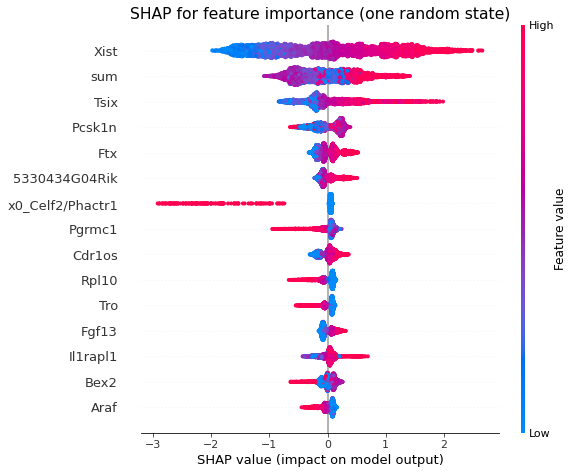

In [18]:
# calculate shap values 
shap_values = explainer.shap_values(X_test5)
print(np.shape(shap_values))

fig = shap.summary_plot(shap_values, X_test5, feature_names = feature_names, max_display=15, show=False)
plt.title('SHAP for feature importance (one random state)')

plt.savefig('./figures/final_shap.pdf')
plt.show()

### Local -- SHAP<a name="12.-shap2"></a>

Text(0.5, 0, 'Xist')

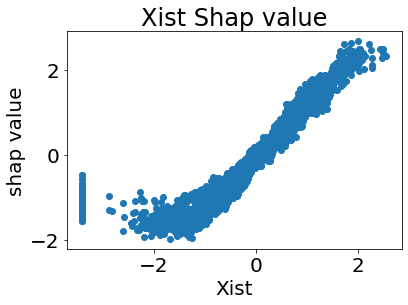

In [19]:
rcParams.update({'font.size': 20})
ftr = 'Xist'
indx = int(np.argwhere(np.array(feature_names)==ftr))

plt.scatter(X_test5.iloc[:,indx],shap_values[:,indx])
plt.title('Xist Shap value')
plt.ylabel('shap value')
plt.xlabel(ftr)

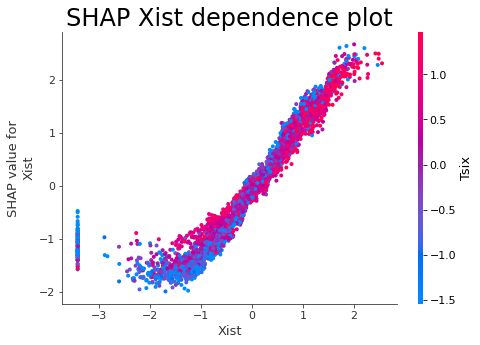

In [20]:
fig = shap.dependence_plot(ftr, shap_values, X_test5, feature_names=feature_names, show=False)
plt.title('SHAP Xist dependence plot')

plt.savefig('./figures/final_Xist_shap.pdf')
plt.show()

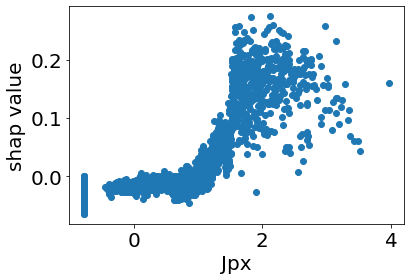

In [21]:
rcParams.update({'font.size': 20})
ftr = 'Jpx'
indx = int(np.argwhere(np.array(feature_names)==ftr))
plt.scatter(X_test5.iloc[:,indx],shap_values[:,indx])
plt.ylabel('shap value')
plt.xlabel(ftr)
plt.show()

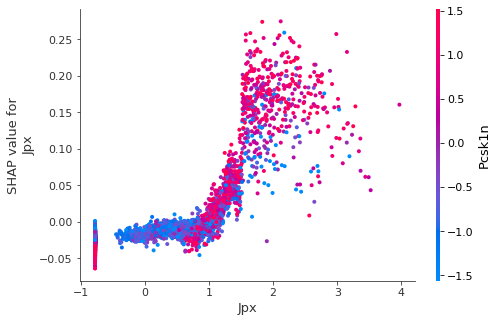

In [24]:
shap.dependence_plot(ftr, shap_values, X_test5, feature_names=feature_names)

In [25]:
index=0
print(explainer.expected_value) # the mean
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test5.iloc[index,:],feature_names = feature_names)

0.37281433


In [26]:
index=2500
print(explainer.expected_value) # the mean
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test5.iloc[index,:],feature_names = feature_names)

0.37281433


In [28]:
index=5000
print(explainer.expected_value) # the mean
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test5.iloc[index,:],feature_names = feature_names)

0.37281433
